In [ ]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tarfile
from pathlib import Path

if Path("data").exists() == False:
    tar = tarfile.open("dentalData.tar")
    tar.extractall("data")
    tar.close()

## Custom Dataset

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import json




class DentalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super().__init__()

        self.data_dir = Path(data_dir)

        self.all_img_paths = list(data_dir.glob("train/img/*"))
        # self.all_mask_paths = list(data_dir.glob("train/ann/*"))
        self.transform = transform

    def __len__(self):
        return len(self.all_img_paths)


    def __getitem__(self, index):

        img_pth = self.all_img_paths[index]
        image = Image.open(img_pth)
        img_array = np.array(image)

        mask_path = self.data_dir / Path("train/ann") / Path(f"{img_pth.name}.json")

        with open(mask_path, 'rb') as file:
            masks = json.load(file)
            masks = masks["objects"]

        raw_mask = Image.new('L', img_array.shape[:-1][::-1], 0)

        for tooth in masks:
            pts = tooth["points"]["exterior"]
            ImageDraw.Draw(raw_mask).polygon(pts, outline=1, fill=1)

        if self.transform != None:

            img_array, raw_mask = self.transform(img_array, raw_mask)

        return (img_array, raw_mask)


## Model Parts

In [ ]:
import torch
from torch import nn
import torchvision

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

        )

    def forward(self, x : torch.Tensor):
        return self.conv(x)


class UNET(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        for feature in features:
            self.downs.append(
                DoubleConv(in_channels, feature)
            )
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                    nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                    )
            self.ups.append(DoubleConv(in_channels=feature*2, out_channels=feature))

        self.bottleneck = DoubleConv(features[-1], out_channels=features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels=out_channels, kernel_size=3, padding=1, stride=1)


    def forward(self, x : torch.Tensor):
        skip_connections : list[torch.Tensor] = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]


        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)

            if x.shape != skip_connections[i//2].shape:
                x = torchvision.transforms.Resize(skip_connections[i//2].shape[2:])(x)

            concat_skip = torch.cat([x, skip_connections[i//2]], dim=1)
            x = self.ups[i+1](concat_skip)

        return self.final_conv(x)

# Main

## Plot

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(2448, 3696, 3)

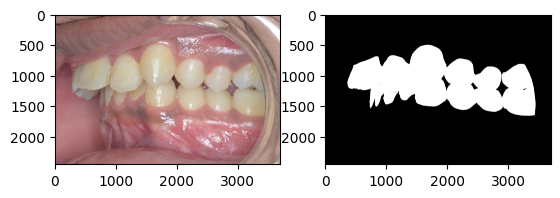

In [ ]:
main_path = Path("data")

data = DentalDataset(data_dir=main_path)

im, m = data[10]

plt.subplot(1, 2, 1)
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.imshow(m, cmap=plt.cm.gray)

im.shape

## Model Instantiation

In [ ]:
model = UNET(3, 1)

x = torch.randn(12, 3, 160, 240)

model.eval()
with torch.inference_mode():
    output = model(x)

model.to(device)

output.shape

torch.Size([12, 1, 160, 240])

In [ ]:
%pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, input_data=x.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [12, 1, 160, 240]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [12, 64, 160, 240]        --
│    │    └─Sequential: 3-1              [12, 64, 160, 240]        38,912
├─MaxPool2d: 1-2                         [12, 64, 80, 120]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [12, 128, 80, 120]        --
│    │    └─Sequential: 3-2              [12, 128, 80, 120]        221,824
├─MaxPool2d: 1-4                         [12, 128, 40, 60]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [12, 256, 40, 60]         --
│    │    └─Sequential: 3-3              [12, 256, 40, 60]         886,016
├─MaxPool2d: 1-6                         [12

## Transform fn

In [ ]:
from torchvision.transforms import v2
import random


def train_transforms(img, mask):

    def get_random():
        return torch.rand(1).item()

    img = v2.ToImage()(img)
    mask = v2.ToImage()(mask)

    img = v2.Resize((160, 240))(img)
    mask = v2.Resize((160, 240))(mask)

    if get_random() > 0.5:
        img = v2.RandomHorizontalFlip(p=1)(img)
        mask = v2.RandomHorizontalFlip(p=1)(mask)

    if get_random() > 0.5:
        img = v2.RandomVerticalFlip(p=1)(img)
        mask = v2.RandomVerticalFlip(p=1)(mask)

    img = v2.ToDtype(torch.float32, scale=True)(img)
    mask = v2.ToDtype(torch.float32, scale=True)(mask)

    return (img, mask)


In [ ]:
torch.rand(1).item()

0.851085901260376

## DataLoader

In [ ]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_data = DentalDataset(data_dir=main_path, transform=train_transforms)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)


(torch.Size([3, 160, 240]), torch.Size([1, 160, 240]))

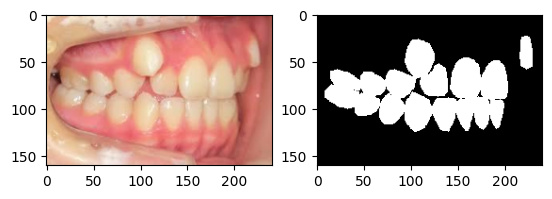

In [ ]:
im_t, m_t = train_data[random.randint(0, 1000)]

plt.subplot(1, 2, 1)
plt.imshow(im_t.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(m_t.permute(1, 2, 0), cmap=plt.cm.gray)

im_t.shape, m_t.shape

## Training

In [ ]:
import torch
from tqdm import tqdm

LR = 1e-4
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

def train_step():
    for batch, (img_batch, mask_batch) in enumerate(tqdm(train_dataloader)):
        torch.cuda.empty_cache()

        model.train()

        output_masks = model(img_batch.to(device))

        loss : torch.Tensor = loss_fn(output_masks, mask_batch.to(device))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 10 == 0:
            print("Loss : ", loss.item())


            plt.subplot(1, 2, 1)
            plt.imshow(mask_batch[0].squeeze(), cmap=plt.cm.gray)

            plt.subplot(1, 2, 2)
            cpu_output_masks = output_masks.detach().to('cpu')
            plt.imshow(cpu_output_masks[0].squeeze(), cmap=plt.cm.gray)

            plt.show()
        model.eval()

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.51646488904953


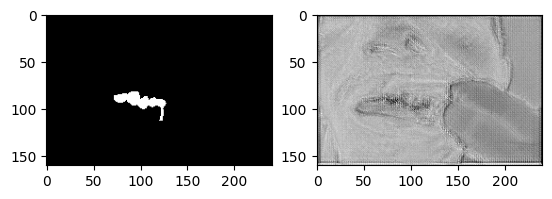

 16%|█▌        | 10/63 [00:48<04:00,  4.55s/it]

Loss :  0.37102654576301575


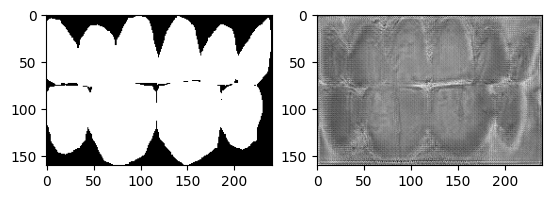

 32%|███▏      | 20/63 [01:39<03:32,  4.93s/it]

Loss :  0.2809929847717285


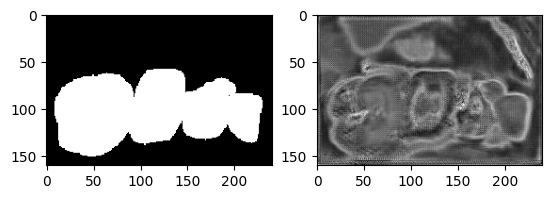

 48%|████▊     | 30/63 [02:32<03:03,  5.57s/it]

Loss :  0.21817800402641296


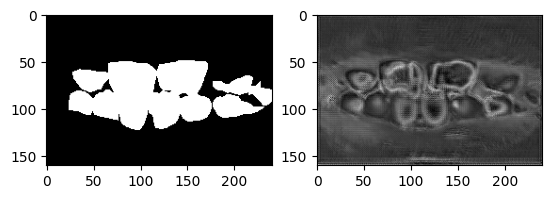

 63%|██████▎   | 40/63 [03:27<02:00,  5.24s/it]

Loss :  0.17484912276268005


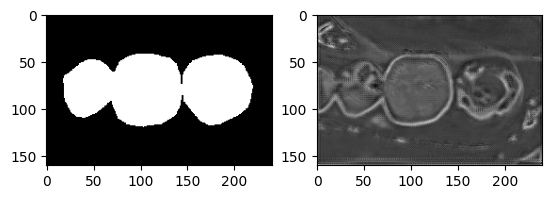

 79%|███████▉  | 50/63 [04:11<00:58,  4.53s/it]

Loss :  0.14220787584781647


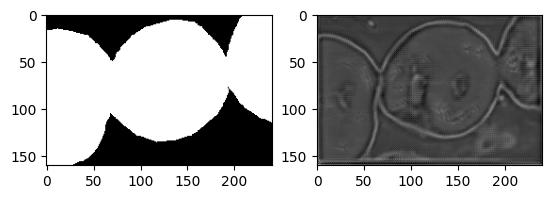

 95%|█████████▌| 60/63 [04:58<00:13,  4.55s/it]

Loss :  0.11972365528345108


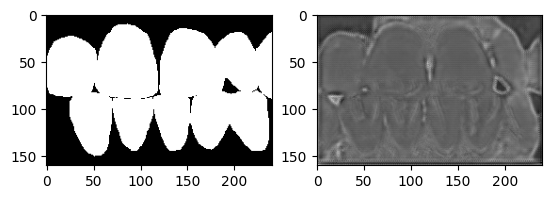

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.11318405717611313


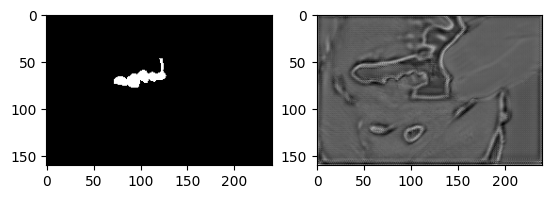

 16%|█▌        | 10/63 [00:46<03:53,  4.40s/it]

Loss :  0.09828823059797287


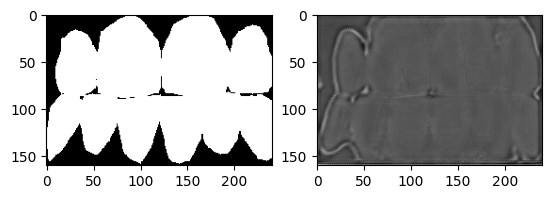

 32%|███▏      | 20/63 [01:36<03:21,  4.70s/it]

Loss :  0.08650272339582443


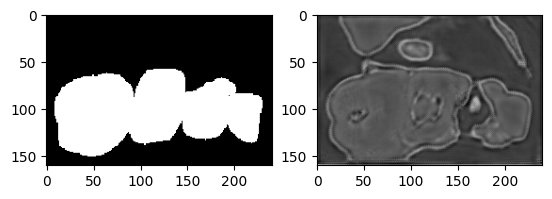

 48%|████▊     | 30/63 [02:30<03:10,  5.77s/it]

Loss :  0.07633010298013687


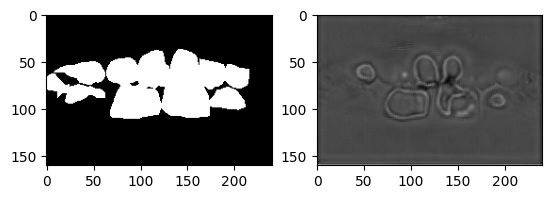

 63%|██████▎   | 40/63 [03:24<01:58,  5.14s/it]

Loss :  0.06928370147943497


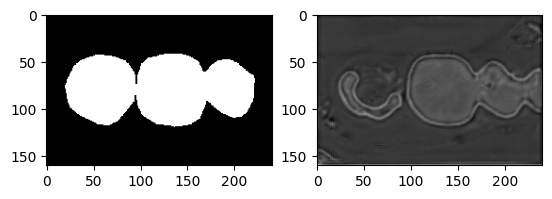

 79%|███████▉  | 50/63 [04:08<00:56,  4.38s/it]

Loss :  0.061847928911447525


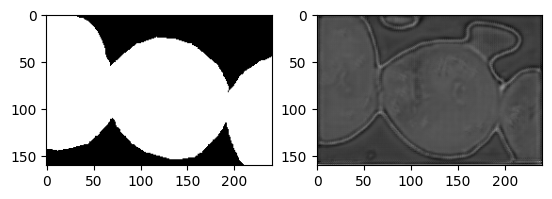

 95%|█████████▌| 60/63 [04:54<00:13,  4.55s/it]

Loss :  0.056163568049669266


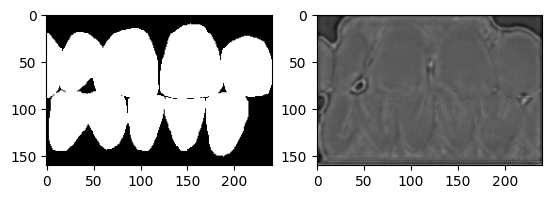

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.05420693755149841


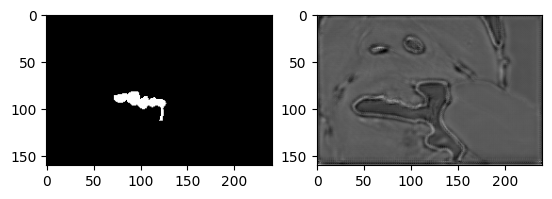

 16%|█▌        | 10/63 [00:46<03:56,  4.45s/it]

Loss :  0.05061112344264984


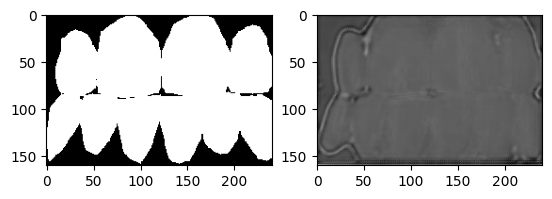

 32%|███▏      | 20/63 [01:36<03:25,  4.78s/it]

Loss :  0.04664691537618637


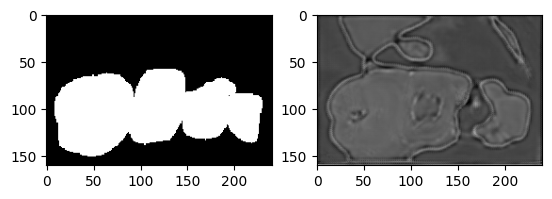

 48%|████▊     | 30/63 [02:26<02:53,  5.25s/it]

Loss :  0.04283570870757103


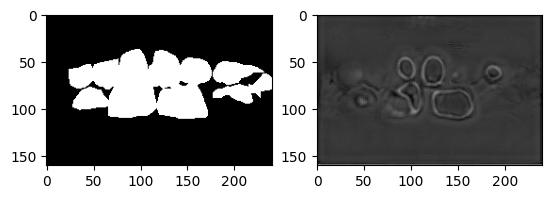

 63%|██████▎   | 40/63 [03:16<01:49,  4.74s/it]

Loss :  0.04035525396466255


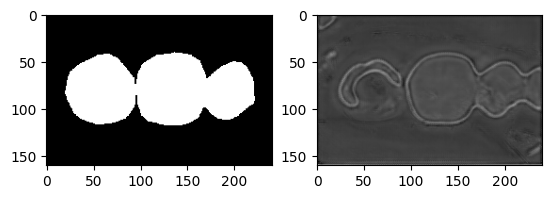

 79%|███████▉  | 50/63 [03:57<00:54,  4.21s/it]

Loss :  0.03703701123595238


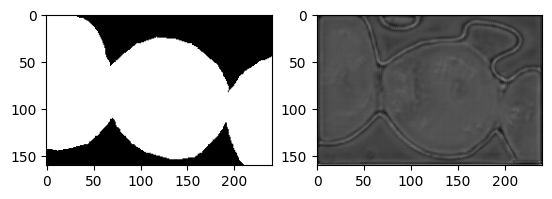

 95%|█████████▌| 60/63 [04:40<00:12,  4.23s/it]

Loss :  0.03442605584859848


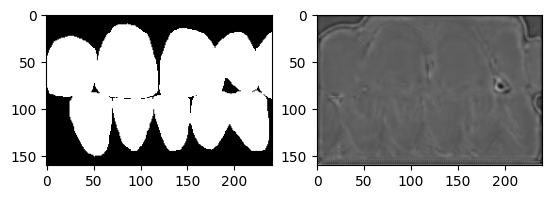

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.03371080011129379


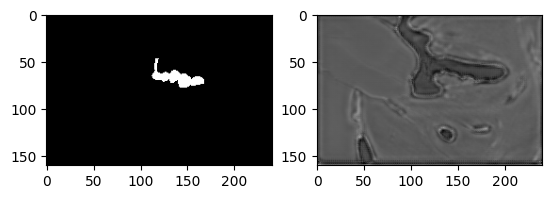

 16%|█▌        | 10/63 [00:41<03:37,  4.10s/it]

Loss :  0.03186442330479622


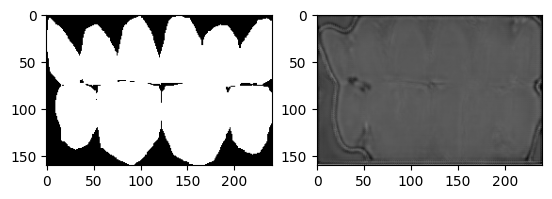

 32%|███▏      | 20/63 [01:27<03:09,  4.41s/it]

Loss :  0.03035665675997734


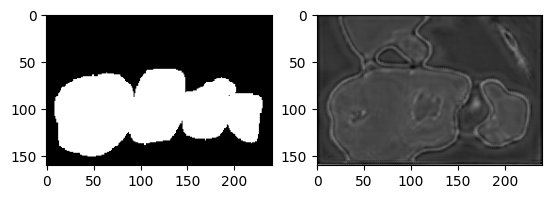

 48%|████▊     | 30/63 [02:16<02:53,  5.26s/it]

Loss :  0.028469344601035118


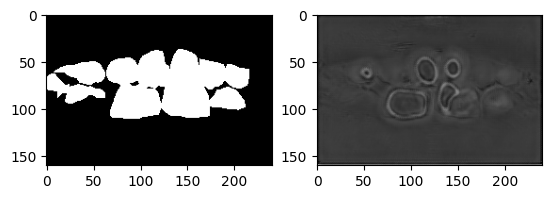

 63%|██████▎   | 40/63 [03:06<01:49,  4.77s/it]

Loss :  0.027637990191578865


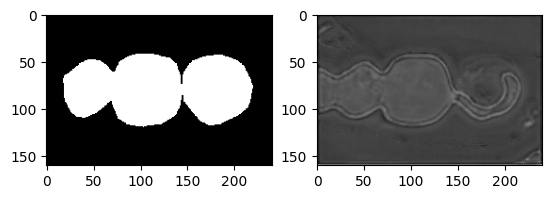

 79%|███████▉  | 50/63 [03:47<00:53,  4.15s/it]

Loss :  0.02575012482702732


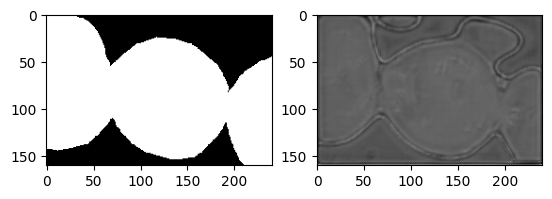

 95%|█████████▌| 60/63 [04:31<00:12,  4.27s/it]

Loss :  0.0243026502430439


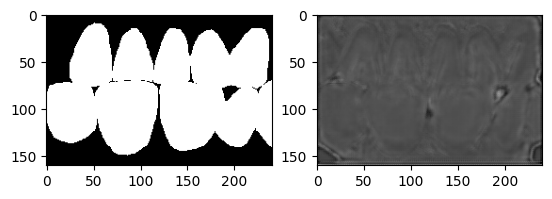

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.02389843948185444


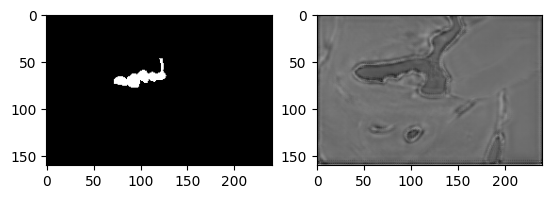

 16%|█▌        | 10/63 [00:41<03:28,  3.94s/it]

Loss :  0.02301875501871109


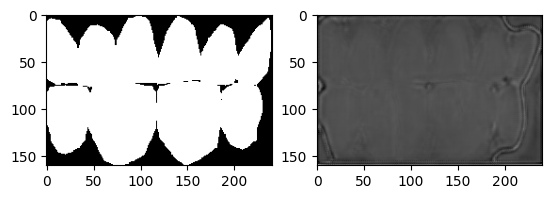

 32%|███▏      | 20/63 [01:26<03:04,  4.29s/it]

Loss :  0.022408783435821533


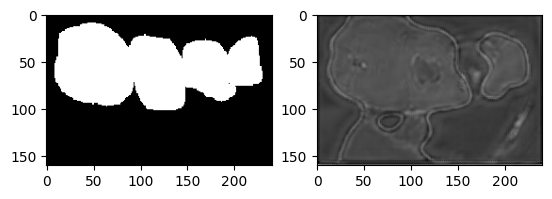

 48%|████▊     | 30/63 [02:16<02:47,  5.08s/it]

Loss :  0.02120354399085045


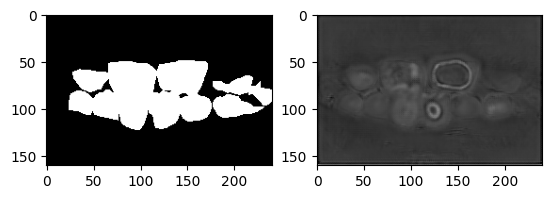

 63%|██████▎   | 40/63 [03:07<01:52,  4.90s/it]

Loss :  0.021146072074770927


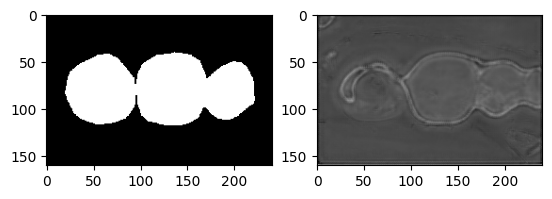

 79%|███████▉  | 50/63 [03:47<00:54,  4.18s/it]

Loss :  0.01980804279446602


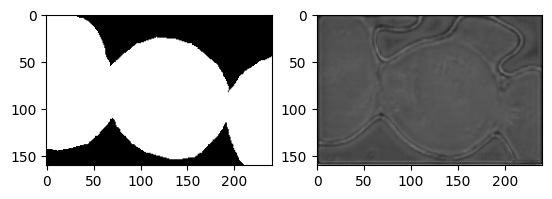

 95%|█████████▌| 60/63 [04:31<00:12,  4.30s/it]

Loss :  0.018841851502656937


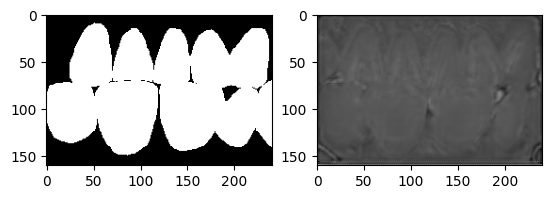

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.018598223105072975


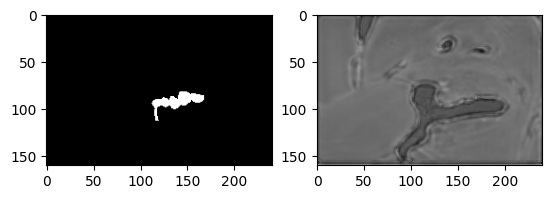

 16%|█▌        | 10/63 [00:41<03:37,  4.10s/it]

Loss :  0.01814139448106289


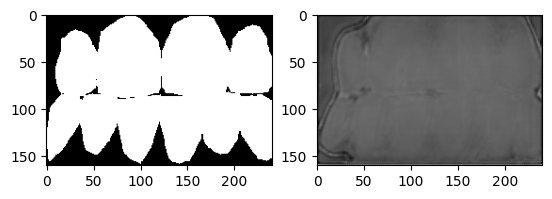

 32%|███▏      | 20/63 [01:26<03:05,  4.32s/it]

Loss :  0.017956458032131195


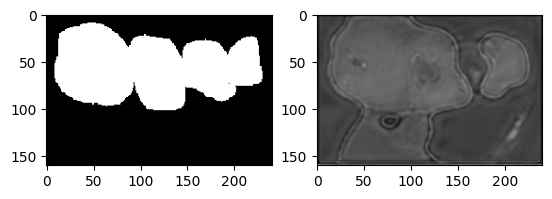

 48%|████▊     | 30/63 [02:16<02:49,  5.14s/it]

Loss :  0.016963498666882515


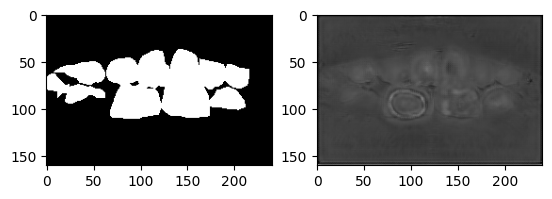

 63%|██████▎   | 40/63 [03:07<01:50,  4.82s/it]

Loss :  0.017366532236337662


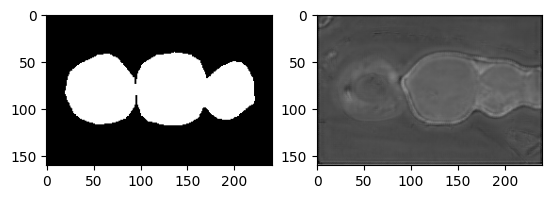

 79%|███████▉  | 50/63 [03:47<00:54,  4.20s/it]

Loss :  0.01629374921321869


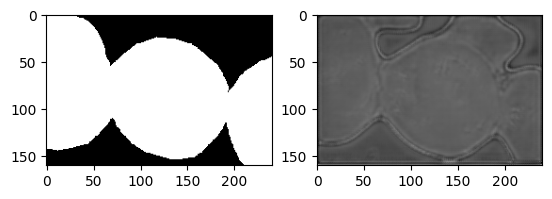

 95%|█████████▌| 60/63 [04:30<00:12,  4.19s/it]

Loss :  0.015565138310194016


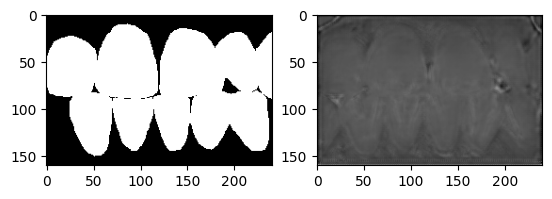

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.015405858866870403


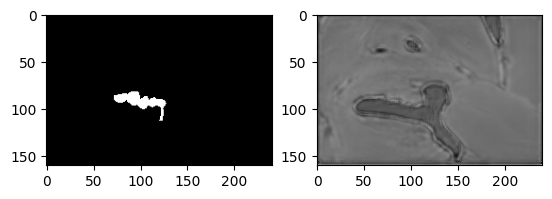

 16%|█▌        | 10/63 [00:42<03:40,  4.16s/it]

Loss :  0.015164966695010662


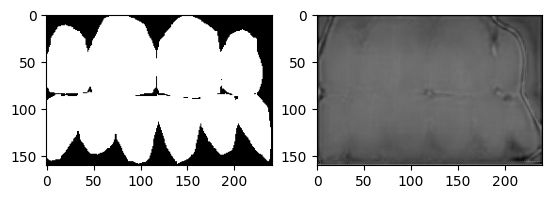

 32%|███▏      | 20/63 [01:26<03:03,  4.26s/it]

Loss :  0.015210679732263088


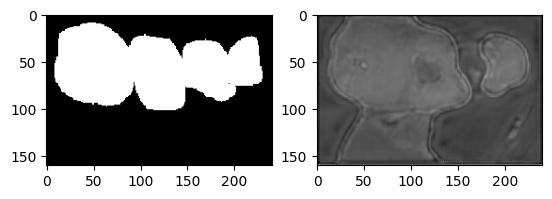

 48%|████▊     | 30/63 [02:18<02:55,  5.31s/it]

Loss :  0.014354415237903595


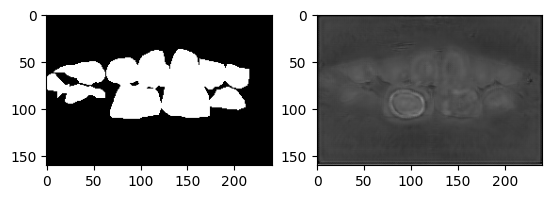

 63%|██████▎   | 40/63 [03:08<01:52,  4.88s/it]

Loss :  0.014968217350542545


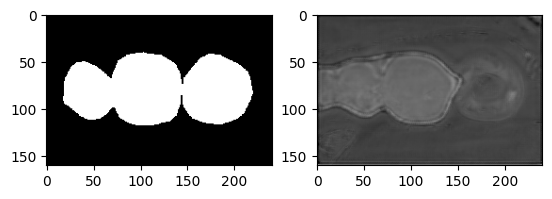

 79%|███████▉  | 50/63 [03:48<00:54,  4.22s/it]

Loss :  0.014040278270840645


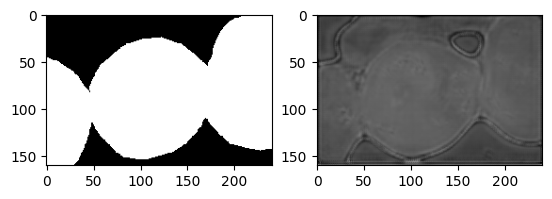

 95%|█████████▌| 60/63 [04:32<00:12,  4.28s/it]

Loss :  0.013455705717206001


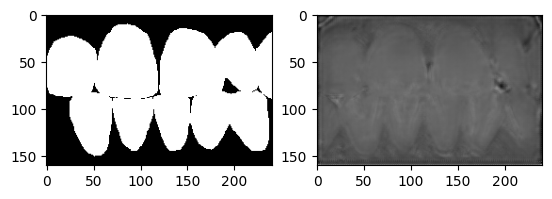

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.013332839123904705


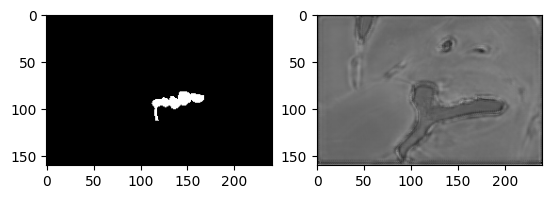

 16%|█▌        | 10/63 [00:41<03:33,  4.03s/it]

Loss :  0.013228979893028736


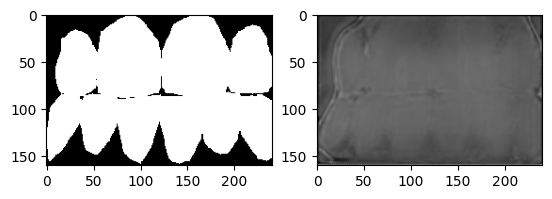

 32%|███▏      | 20/63 [01:27<03:06,  4.35s/it]

Loss :  0.013419236056506634


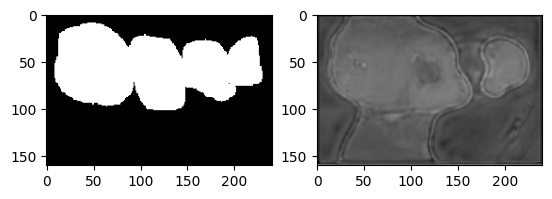

 48%|████▊     | 30/63 [02:16<02:50,  5.16s/it]

Loss :  0.012644483707845211


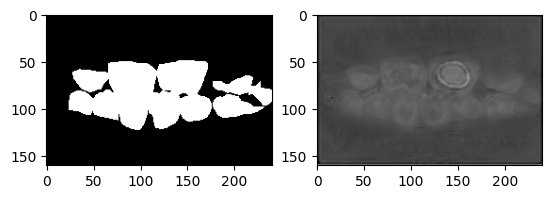

 63%|██████▎   | 40/63 [03:07<01:47,  4.69s/it]

Loss :  0.013399134390056133


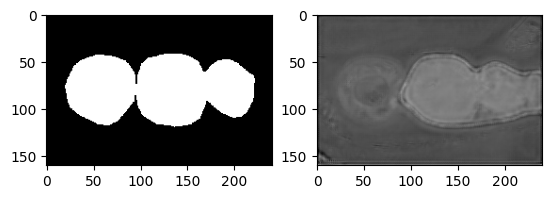

 79%|███████▉  | 50/63 [03:48<00:55,  4.28s/it]

Loss :  0.012540441006422043


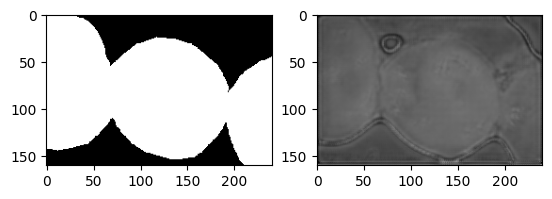

 95%|█████████▌| 60/63 [04:31<00:12,  4.24s/it]

Loss :  0.012030557729303837


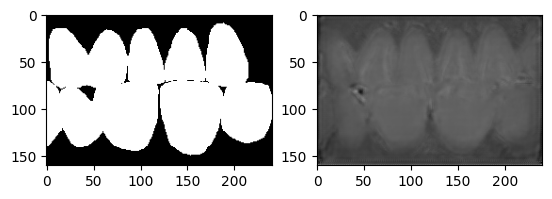

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.011932199820876122


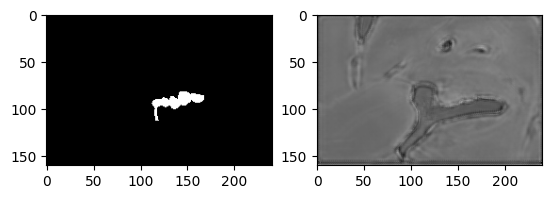

 16%|█▌        | 10/63 [00:44<04:00,  4.53s/it]

Loss :  0.011891023255884647


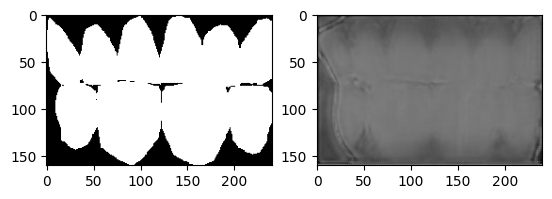

 32%|███▏      | 20/63 [01:33<03:14,  4.53s/it]

Loss :  0.012178272008895874


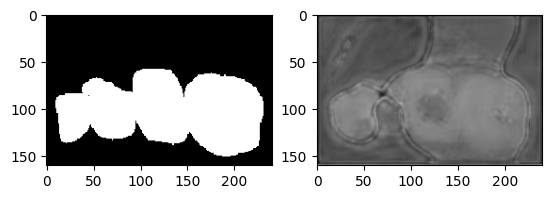

 48%|████▊     | 30/63 [02:28<03:05,  5.61s/it]

Loss :  0.01143951341509819


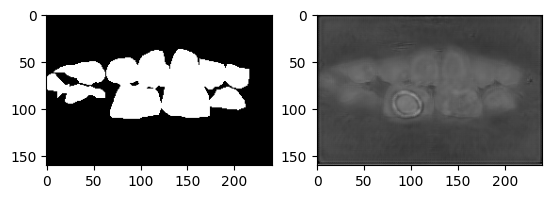

 63%|██████▎   | 40/63 [03:23<01:58,  5.16s/it]

Loss :  0.012288210913538933


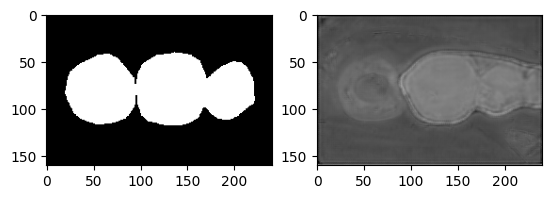

 79%|███████▉  | 50/63 [04:07<00:59,  4.56s/it]

Loss :  0.011476038955152035


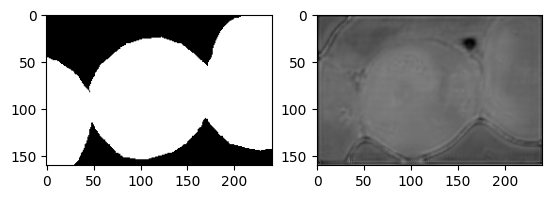

 95%|█████████▌| 60/63 [04:55<00:14,  4.71s/it]

Loss :  0.011007306165993214


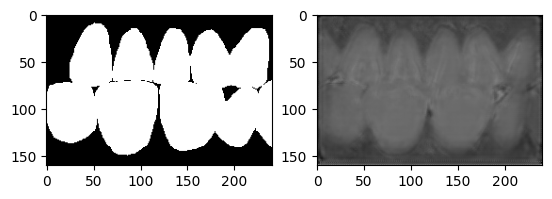

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.010913512669503689


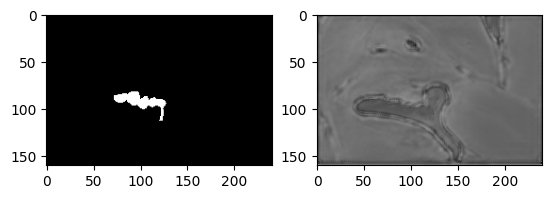

 16%|█▌        | 10/63 [00:46<03:52,  4.39s/it]

Loss :  0.010931172408163548


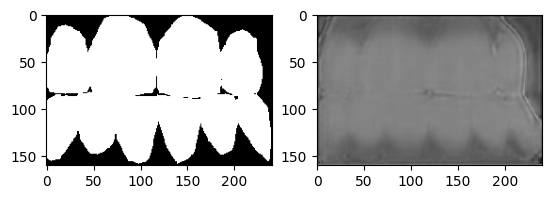

 32%|███▏      | 20/63 [01:33<03:18,  4.62s/it]

Loss :  0.011284034699201584


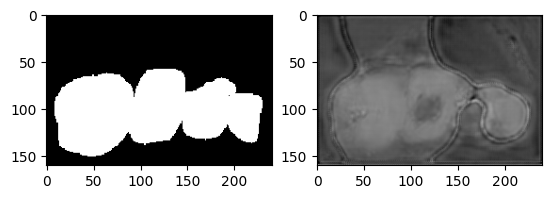

 48%|████▊     | 30/63 [02:26<03:08,  5.71s/it]

Loss :  0.0105748251080513


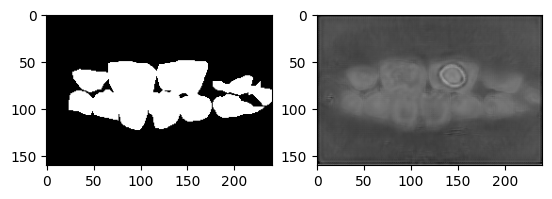

 63%|██████▎   | 40/63 [03:19<01:55,  5.01s/it]

Loss :  0.011485747061669827


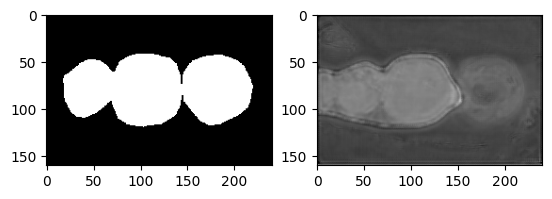

 79%|███████▉  | 50/63 [04:02<00:56,  4.35s/it]

Loss :  0.010706418193876743


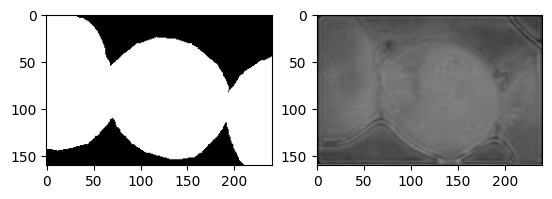

 95%|█████████▌| 60/63 [04:50<00:13,  4.64s/it]

Loss :  0.010248989798128605


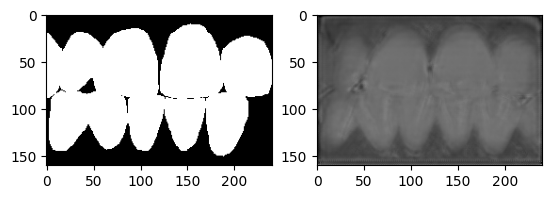

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.010165783576667309


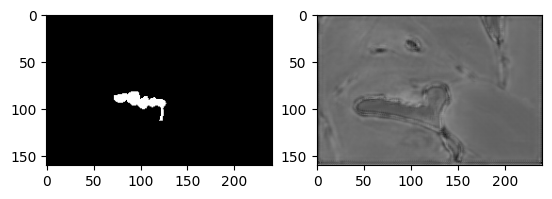

 16%|█▌        | 10/63 [00:46<03:53,  4.40s/it]

Loss :  0.010214187204837799


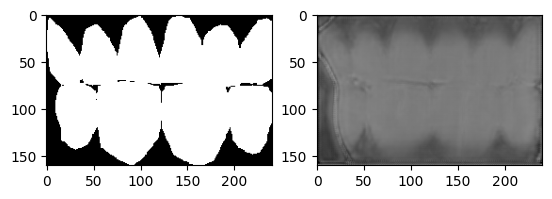

 32%|███▏      | 20/63 [01:36<03:26,  4.80s/it]

Loss :  0.01063147746026516


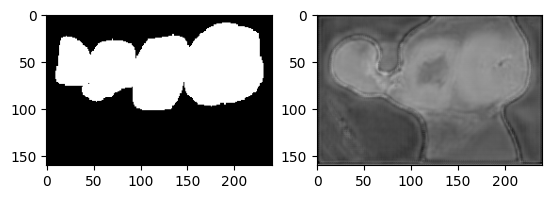

 48%|████▊     | 30/63 [02:28<02:59,  5.44s/it]

Loss :  0.009910079650580883


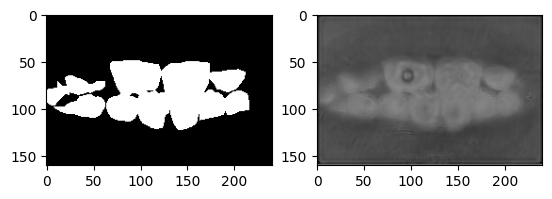

 63%|██████▎   | 40/63 [03:21<01:53,  4.93s/it]

Loss :  0.010888325981795788


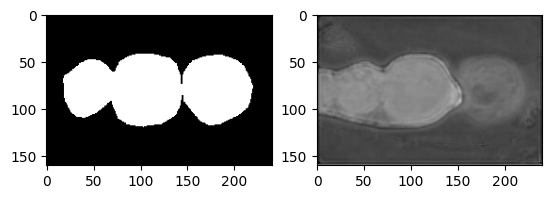

 79%|███████▉  | 50/63 [04:05<00:58,  4.53s/it]

Loss :  0.010131376795470715


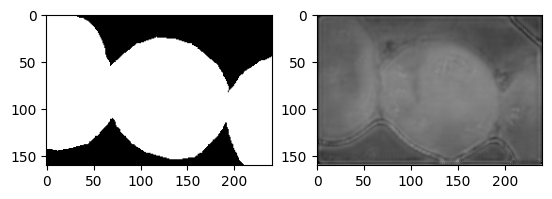

 95%|█████████▌| 60/63 [04:51<00:13,  4.52s/it]

Loss :  0.0096836406737566


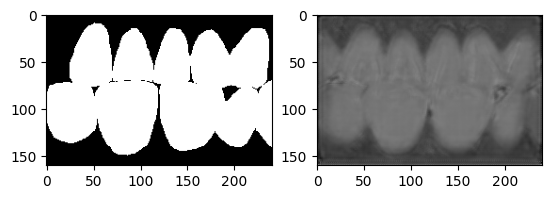

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.00961368065327406


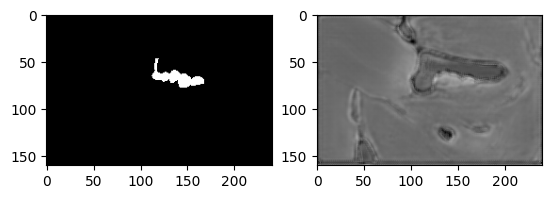

 16%|█▌        | 10/63 [00:46<03:59,  4.53s/it]

Loss :  0.009668533690273762


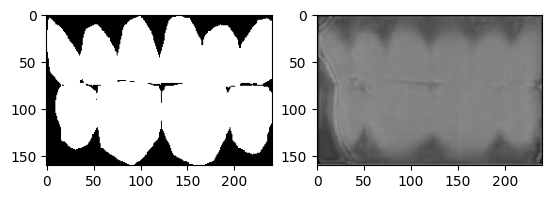

 32%|███▏      | 20/63 [01:36<03:24,  4.77s/it]

Loss :  0.010113679803907871


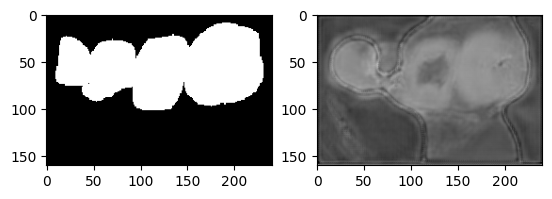

 48%|████▊     | 30/63 [02:28<03:01,  5.49s/it]

Loss :  0.00940820574760437


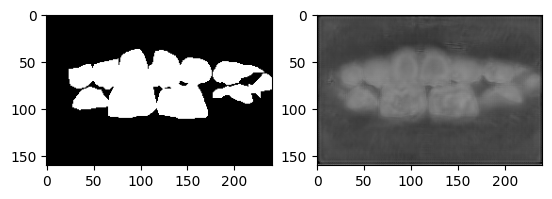

 63%|██████▎   | 40/63 [03:23<02:00,  5.23s/it]

Loss :  0.01042879931628704


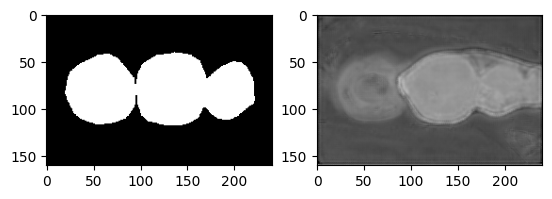

 79%|███████▉  | 50/63 [04:05<00:55,  4.27s/it]

Loss :  0.009677148424088955


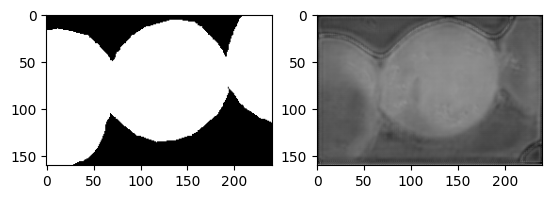

 95%|█████████▌| 60/63 [04:51<00:13,  4.38s/it]

Loss :  0.009247840382158756


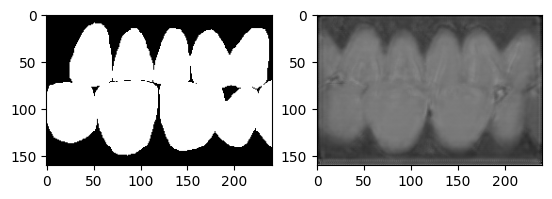

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.009180610068142414


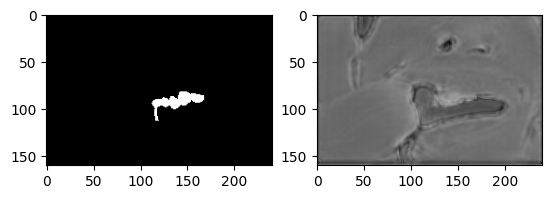

 16%|█▌        | 10/63 [00:43<03:45,  4.26s/it]

Loss :  0.009251491166651249


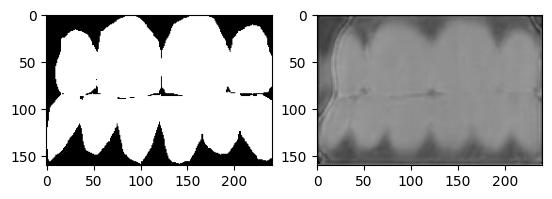

 32%|███▏      | 20/63 [01:29<03:18,  4.61s/it]

Loss :  0.009721498936414719


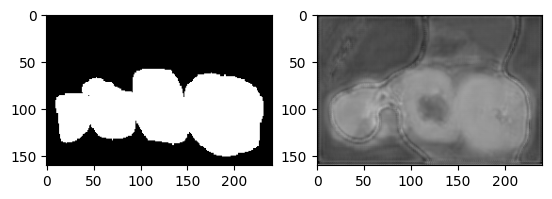

 48%|████▊     | 30/63 [02:20<02:55,  5.33s/it]

Loss :  0.00902208499610424


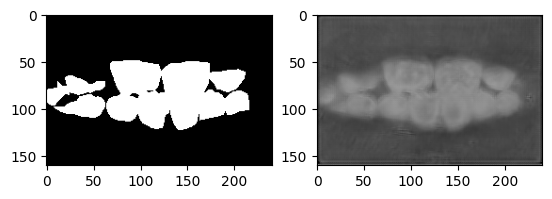

 63%|██████▎   | 40/63 [03:15<01:59,  5.19s/it]

Loss :  0.010068942792713642


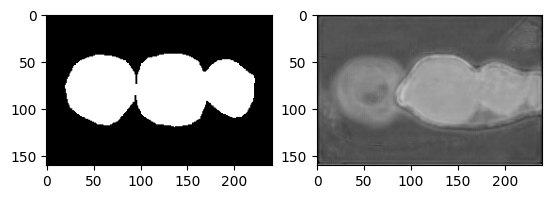

 79%|███████▉  | 50/63 [03:58<00:56,  4.33s/it]

Loss :  0.009317475371062756


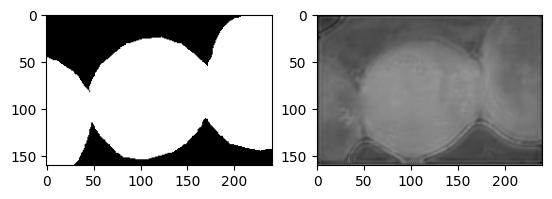

 95%|█████████▌| 60/63 [04:45<00:13,  4.50s/it]

Loss :  0.00889795832335949


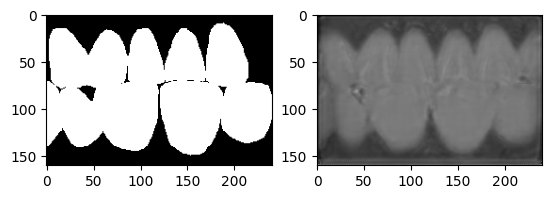

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.008829066529870033


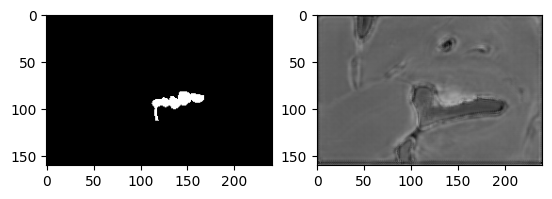

 16%|█▌        | 10/63 [00:46<04:00,  4.54s/it]

Loss :  0.008926579728722572


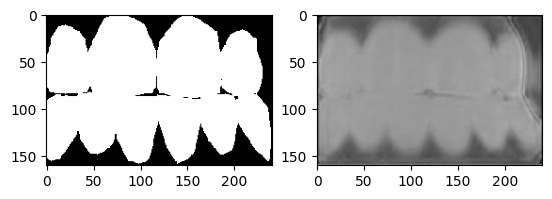

 32%|███▏      | 20/63 [01:36<03:27,  4.84s/it]

Loss :  0.009406507946550846


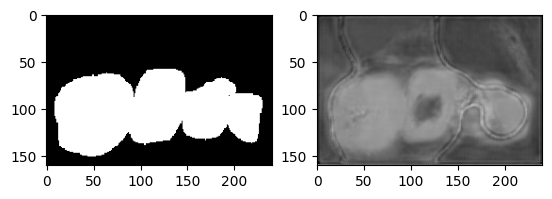

 48%|████▊     | 30/63 [02:26<02:54,  5.29s/it]

Loss :  0.008700334466993809


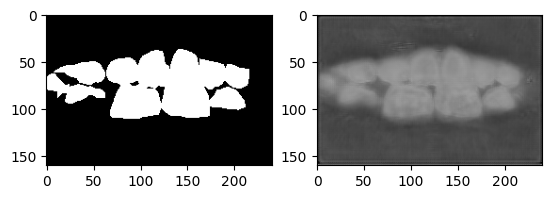

 63%|██████▎   | 40/63 [03:22<02:02,  5.31s/it]

Loss :  0.009778948500752449


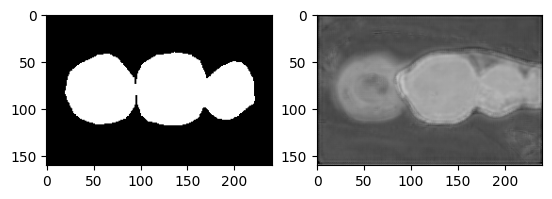

 79%|███████▉  | 50/63 [04:03<00:54,  4.17s/it]

Loss :  0.009039347060024738


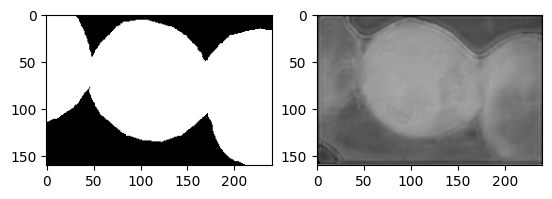

 95%|█████████▌| 60/63 [04:51<00:13,  4.64s/it]

Loss :  0.008611164055764675


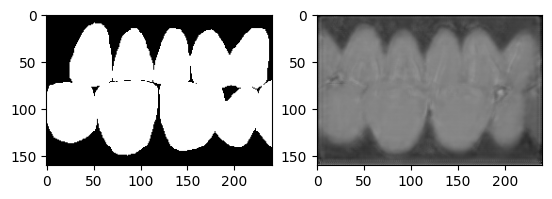

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.008544313721358776


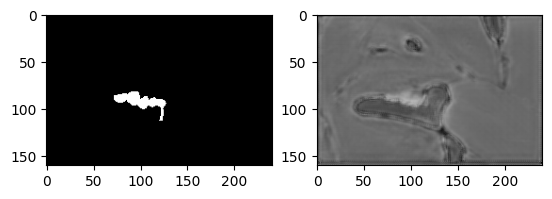

 16%|█▌        | 10/63 [00:46<03:51,  4.37s/it]

Loss :  0.008672423660755157


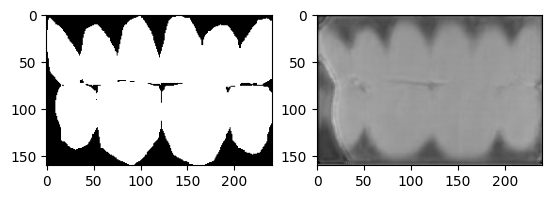

 32%|███▏      | 20/63 [01:35<03:25,  4.78s/it]

Loss :  0.00915954727679491


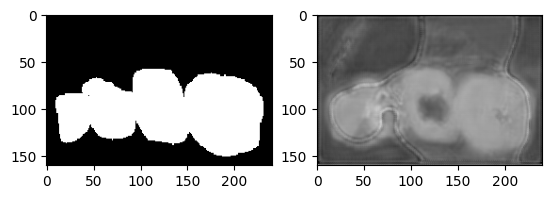

 48%|████▊     | 30/63 [02:27<02:59,  5.44s/it]

Loss :  0.008450072258710861


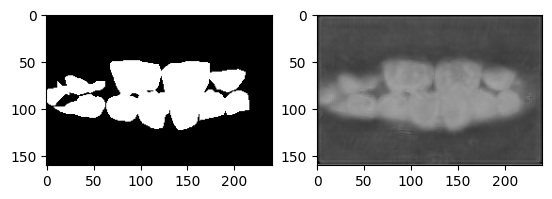

 63%|██████▎   | 40/63 [03:20<01:58,  5.15s/it]

Loss :  0.009543072432279587


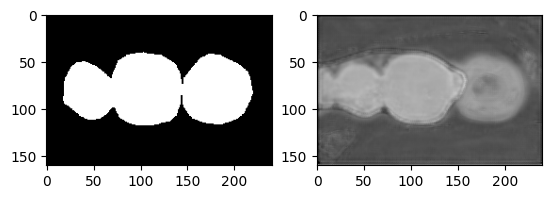

 79%|███████▉  | 50/63 [04:01<00:55,  4.30s/it]

Loss :  0.008796045556664467


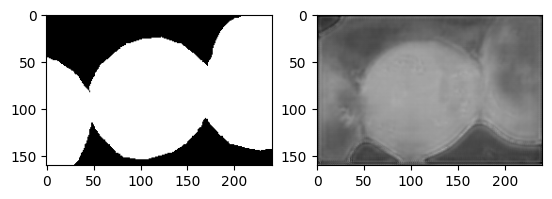

 95%|█████████▌| 60/63 [04:46<00:12,  4.28s/it]

Loss :  0.008358190767467022


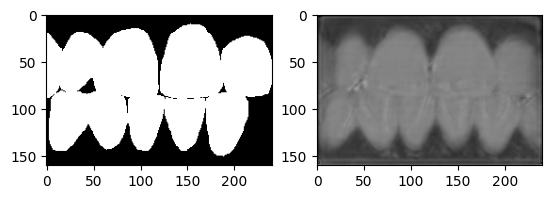

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.008314407430589199


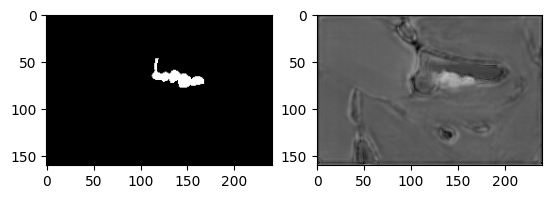

 16%|█▌        | 10/63 [00:43<03:48,  4.30s/it]

Loss :  0.008439544588327408


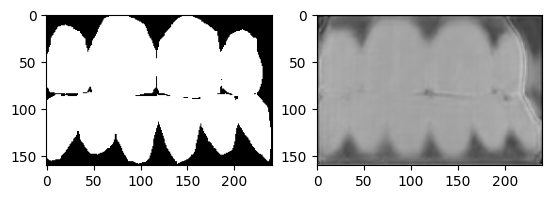

 32%|███▏      | 20/63 [01:29<03:13,  4.50s/it]

Loss :  0.008953594602644444


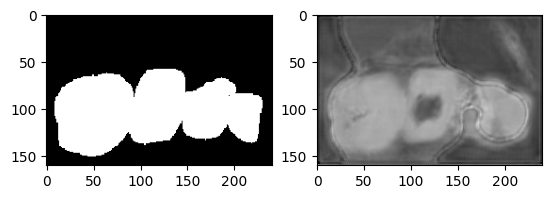

 48%|████▊     | 30/63 [02:20<02:58,  5.41s/it]

Loss :  0.008246523328125477


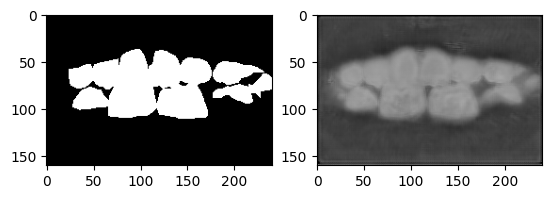

 63%|██████▎   | 40/63 [03:12<01:50,  4.82s/it]

Loss :  0.009355958551168442


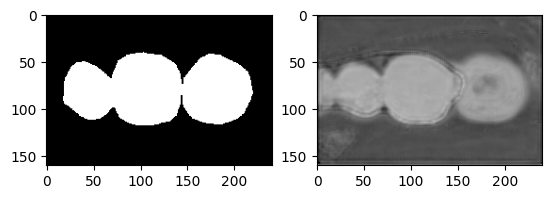

 79%|███████▉  | 50/63 [03:53<00:56,  4.31s/it]

Loss :  0.00860768835991621


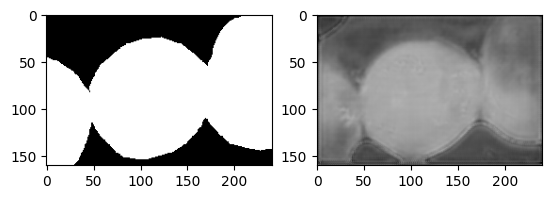

 95%|█████████▌| 60/63 [04:38<00:13,  4.34s/it]

Loss :  0.00816282071173191


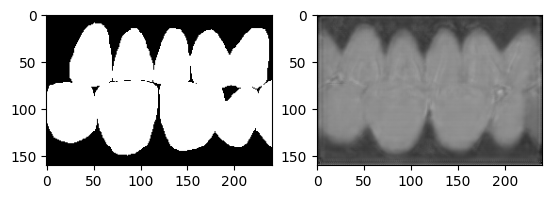

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.008134763687849045


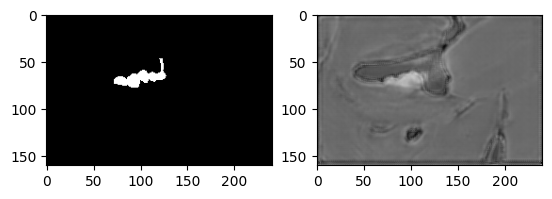

 16%|█▌        | 10/63 [00:42<03:43,  4.21s/it]

Loss :  0.008254059590399265


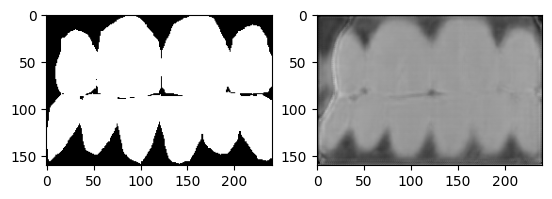

 32%|███▏      | 20/63 [01:29<03:13,  4.51s/it]

Loss :  0.008774670772254467


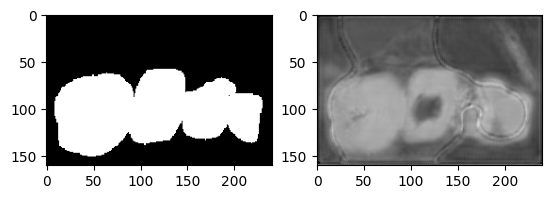

 48%|████▊     | 30/63 [02:21<02:55,  5.33s/it]

Loss :  0.008080193772912025


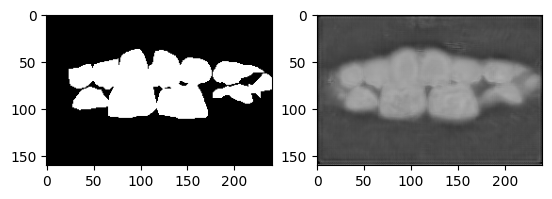

 63%|██████▎   | 40/63 [03:13<01:52,  4.88s/it]

Loss :  0.009202014654874802


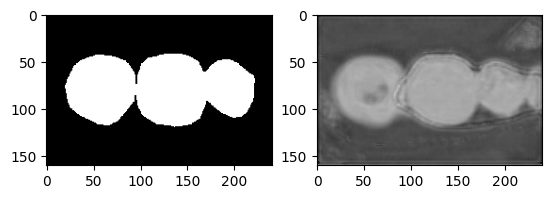

 79%|███████▉  | 50/63 [03:54<00:55,  4.24s/it]

Loss :  0.00845587719231844


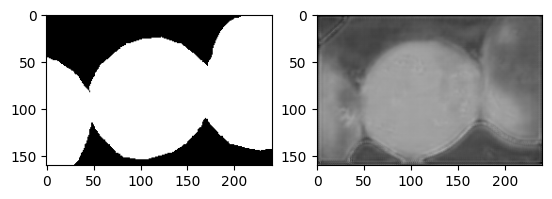

 95%|█████████▌| 60/63 [04:39<00:13,  4.49s/it]

Loss :  0.008012499660253525


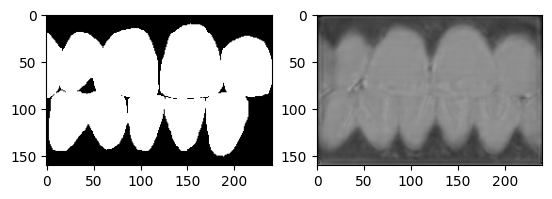

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.007972472347319126


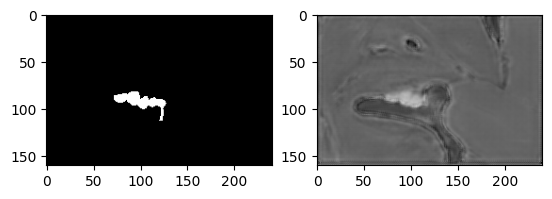

 16%|█▌        | 10/63 [00:42<03:42,  4.19s/it]

Loss :  0.008101586252450943


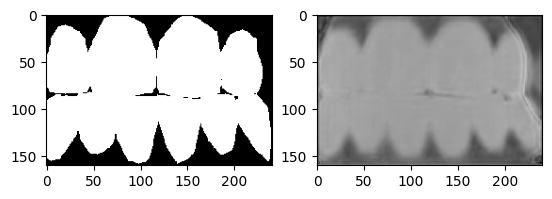

 32%|███▏      | 20/63 [01:30<03:11,  4.46s/it]

Loss :  0.008632034063339233


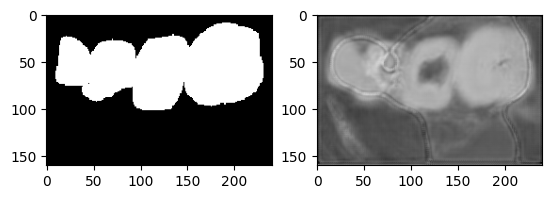

 48%|████▊     | 30/63 [02:20<02:53,  5.26s/it]

Loss :  0.007922045886516571


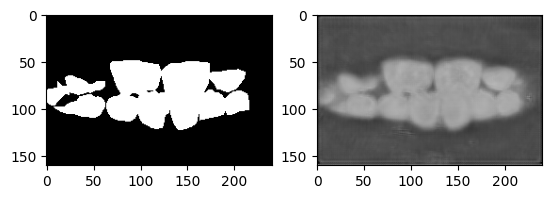

 63%|██████▎   | 40/63 [03:13<01:55,  5.03s/it]

Loss :  0.009078560397028923


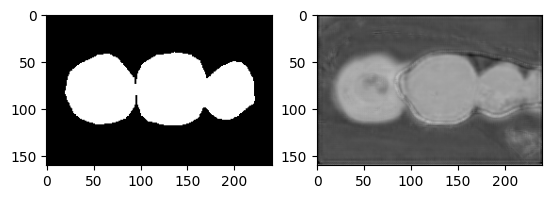

 79%|███████▉  | 50/63 [03:54<00:55,  4.30s/it]

Loss :  0.008326323702931404


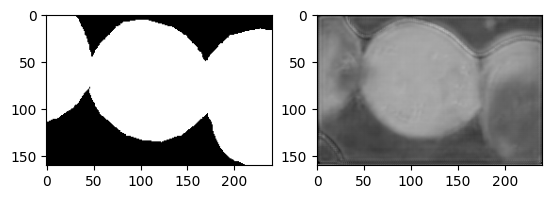

 95%|█████████▌| 60/63 [04:39<00:13,  4.35s/it]

Loss :  0.007877124473452568


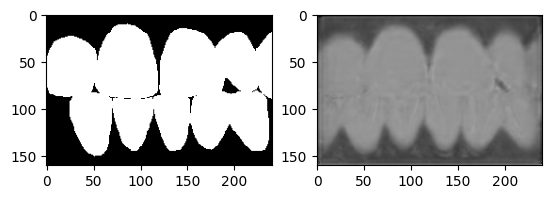

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.0078369015827775


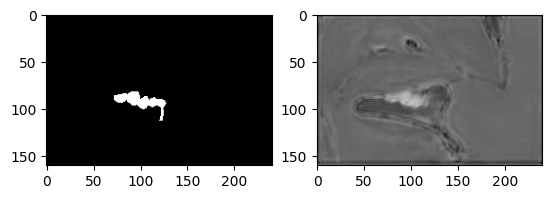

 16%|█▌        | 10/63 [00:43<03:48,  4.31s/it]

Loss :  0.007976572960615158


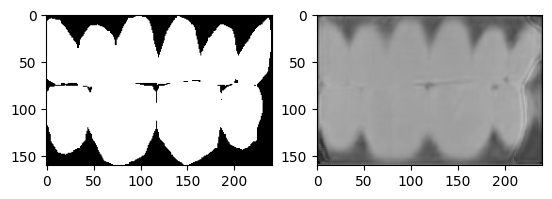

 32%|███▏      | 20/63 [01:28<03:11,  4.45s/it]

Loss :  0.008508439175784588


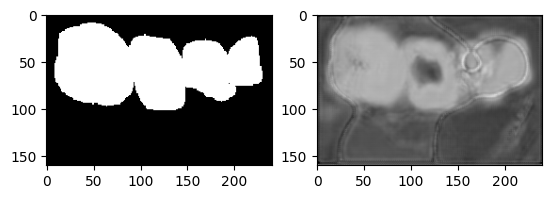

 48%|████▊     | 30/63 [02:20<02:58,  5.41s/it]

Loss :  0.0077956486493349075


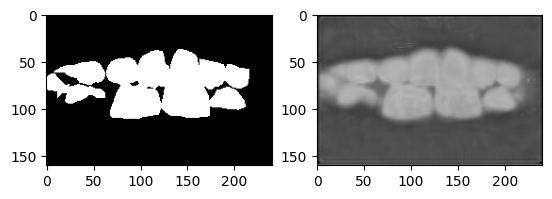

 63%|██████▎   | 40/63 [03:13<01:54,  4.97s/it]

Loss :  0.008963201195001602


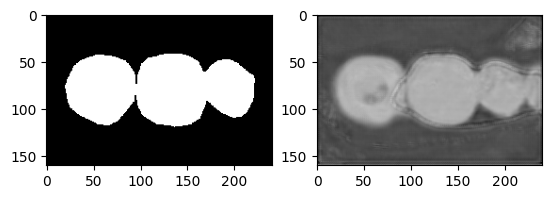

 79%|███████▉  | 50/63 [03:54<00:55,  4.30s/it]

Loss :  0.008226370438933372


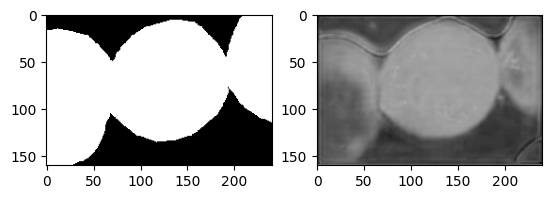

 95%|█████████▌| 60/63 [04:38<00:12,  4.28s/it]

Loss :  0.0077672493644058704


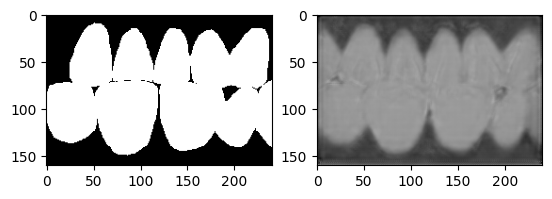

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.0077191609889268875


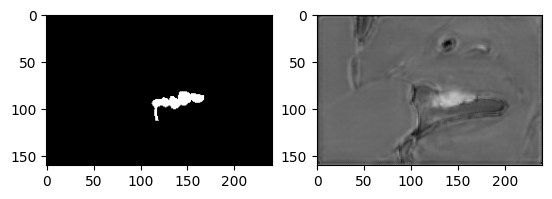

 16%|█▌        | 10/63 [00:43<03:49,  4.33s/it]

Loss :  0.007861753925681114


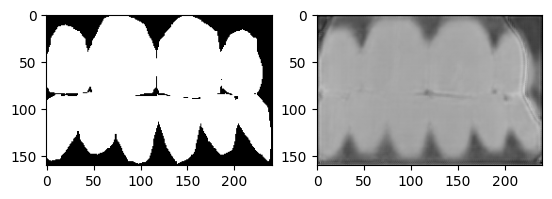

 32%|███▏      | 20/63 [01:29<03:15,  4.54s/it]

Loss :  0.008411254733800888


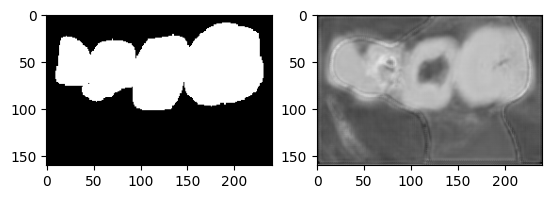

 48%|████▊     | 30/63 [02:20<02:56,  5.36s/it]

Loss :  0.007687368430197239


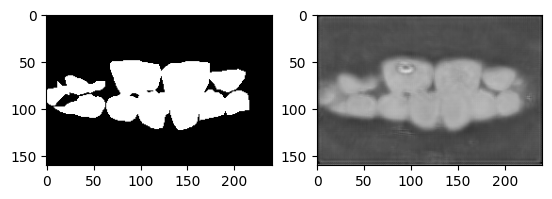

 63%|██████▎   | 40/63 [03:12<01:54,  4.98s/it]

Loss :  0.008867880329489708


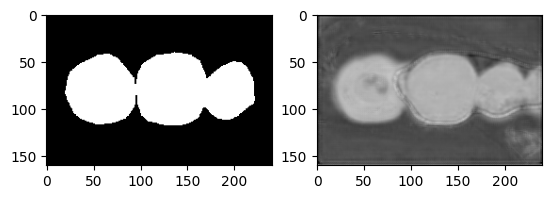

 79%|███████▉  | 50/63 [03:54<00:57,  4.45s/it]

Loss :  0.008123726584017277


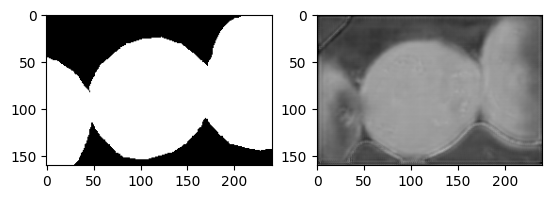

 95%|█████████▌| 60/63 [04:40<00:13,  4.50s/it]

Loss :  0.0076638502068817616


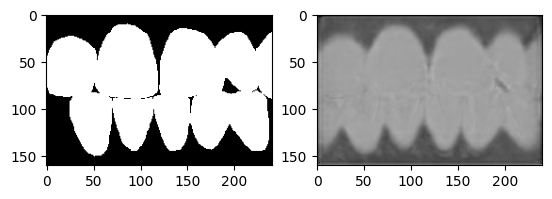

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.007615615613758564


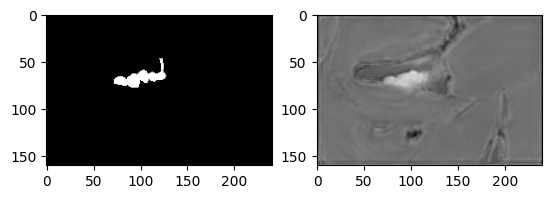

 16%|█▌        | 10/63 [00:43<03:45,  4.26s/it]

Loss :  0.007759148254990578


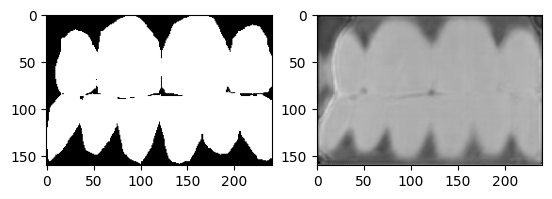

 32%|███▏      | 20/63 [01:30<03:14,  4.52s/it]

Loss :  0.00831642933189869


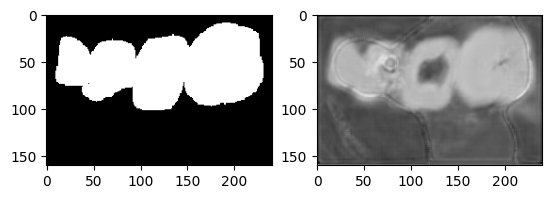

 48%|████▊     | 30/63 [02:22<02:56,  5.35s/it]

Loss :  0.007596535142511129


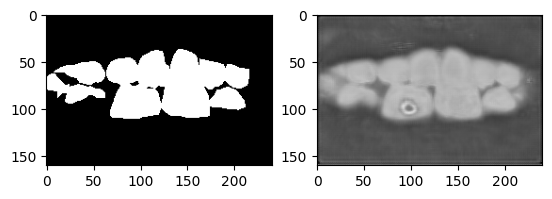

 63%|██████▎   | 40/63 [03:15<01:56,  5.05s/it]

Loss :  0.008784666657447815


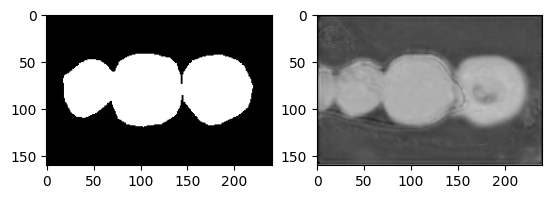

 79%|███████▉  | 50/63 [03:57<00:56,  4.32s/it]

Loss :  0.008033886551856995


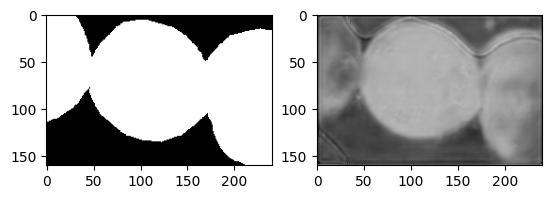

 95%|█████████▌| 60/63 [04:42<00:12,  4.32s/it]

Loss :  0.007577019743621349


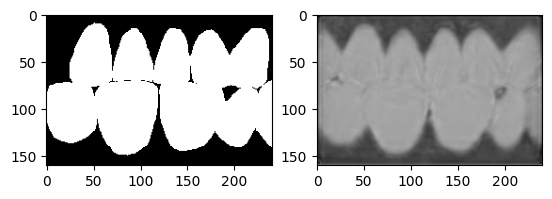

  0%|          | 0/63 [00:00<?, ?it/s]

Loss :  0.0075275409035384655


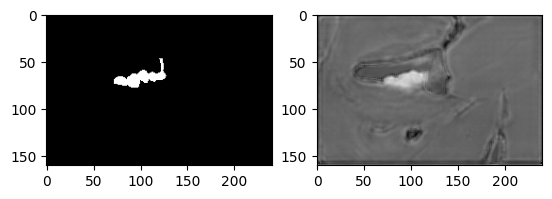

 16%|█▌        | 10/63 [00:42<03:41,  4.17s/it]

Loss :  0.00769412238150835


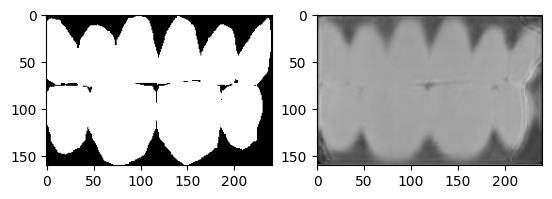

 32%|███▏      | 20/63 [01:30<03:09,  4.40s/it]

Loss :  0.00823572464287281


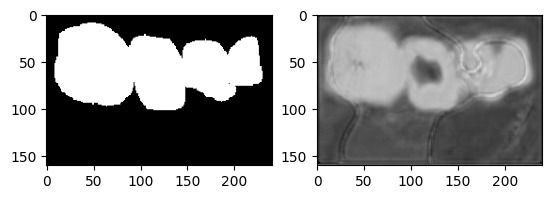

 48%|████▊     | 30/63 [02:22<02:59,  5.44s/it]

Loss :  0.007512196898460388


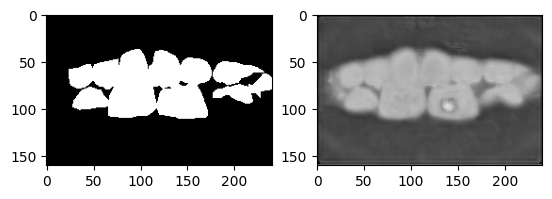

 63%|██████▎   | 40/63 [03:14<01:53,  4.95s/it]

Loss :  0.008706299588084221


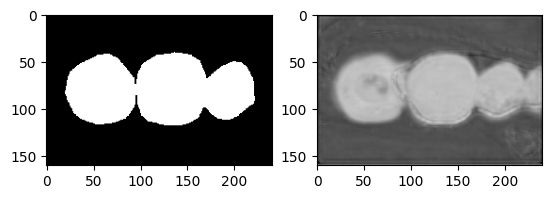

 79%|███████▉  | 50/63 [03:55<00:56,  4.31s/it]

Loss :  0.007985629141330719


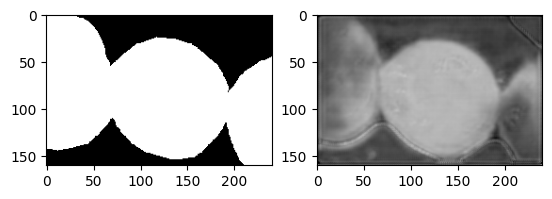

 95%|█████████▌| 60/63 [04:39<00:12,  4.23s/it]

Loss :  0.007510529365390539


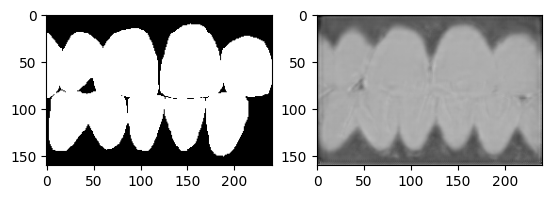

 97%|█████████▋| 61/63 [04:44<00:09,  4.72s/it]

In [ ]:
EPOCHS = 100

for e in range(EPOCHS):

    train_step()

    if e % 10 == 0:
        with open("model_weights{e}.pth", 'wb') as file:
            torch.save(model.state_dict(), file)

In [ ]:
with torch.inference_mode():
  torch.cuda.empty_cache()